#Modules

In [2]:
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

In [57]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import seaborn as sns
import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [215]:
df=pd.read_csv('after_preprocessing.csv')

In [216]:
data=df[['caption', 'hashtags', 'biography']]

In [28]:
from gensim.models.phrases import Phrases, Phraser

#Caption

In [30]:
sent_cap = [str(row).split() for row in data['caption']]

In [31]:
phrases = Phrases(sent_cap, min_count=30, progress_per=10000)

INFO - 10:49:31: collecting all words and their counts
INFO - 10:49:31: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 10:49:32: PROGRESS: at sentence #10000, processed 418087 words and 278239 word types
INFO - 10:49:34: PROGRESS: at sentence #20000, processed 807461 words and 488196 word types
INFO - 10:49:35: PROGRESS: at sentence #30000, processed 1210158 words and 680680 word types
INFO - 10:49:36: PROGRESS: at sentence #40000, processed 1612559 words and 854072 word types
INFO - 10:49:36: collected 923614 word types from a corpus of 1788870 words (unigram + bigrams) and 44159 sentences
INFO - 10:49:36: using 923614 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [32]:
bigram_cap = Phraser(phrases)

INFO - 10:49:49: source_vocab length 923614
INFO - 10:49:59: Phraser built with 2882 phrasegrams


In [33]:
sentences_cap = bigram_cap[sent_cap]

In [4]:
import multiprocessing

from gensim.models import Word2Vec

In [34]:
# I prefer to separate the training in 3 distinctive steps for clarity and monitoring.

# Word2Vec():
# In this first step, I set up the parameters of the model one-by-one.
# I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

# .build_vocab():
# Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
# With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

# .train():
# Finally, trains the model.
# The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [35]:
w2v_model_caption = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [36]:
t = time()

w2v_model_caption.build_vocab(sentences_cap, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:50:26: collecting all words and their counts
INFO - 10:50:26: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:50:28: PROGRESS: at sentence #10000, processed 375856 words, keeping 39009 word types
INFO - 10:50:31: PROGRESS: at sentence #20000, processed 725579 words, keeping 62739 word types
INFO - 10:50:32: PROGRESS: at sentence #30000, processed 1085634 words, keeping 82876 word types
INFO - 10:50:33: PROGRESS: at sentence #40000, processed 1445891 words, keeping 99458 word types
INFO - 10:50:34: collected 105808 word types from a corpus of 1602615 raw words and 44159 sentences
INFO - 10:50:34: Loading a fresh vocabulary
INFO - 10:50:34: effective_min_count=20 retains 10103 unique words (9% of original 105808, drops 95705)
INFO - 10:50:34: effective_min_count=20 leaves 1356398 word corpus (84% of original 1602615, drops 246217)
INFO - 10:50:34: deleting the raw counts dictionary of 105808 items
INFO - 10:50:34: sample=6e-05 downsamples 1265 most-c

Time to build vocab: 0.17 mins


In [38]:
t = time()

w2v_model_caption.train(sentences_cap, total_examples=w2v_model_caption.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

WARNING - 10:50:46: Effective 'alpha' higher than previous training cycles
INFO - 10:50:46: training model with 1 workers on 10103 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 10:50:47: EPOCH 1 - PROGRESS: at 4.71% examples, 35827 words/s, in_qsize 0, out_qsize 0
INFO - 10:50:48: EPOCH 1 - PROGRESS: at 8.97% examples, 35385 words/s, in_qsize 1, out_qsize 0
INFO - 10:50:49: EPOCH 1 - PROGRESS: at 13.76% examples, 38011 words/s, in_qsize 1, out_qsize 0
INFO - 10:50:50: EPOCH 1 - PROGRESS: at 20.10% examples, 42707 words/s, in_qsize 1, out_qsize 0
INFO - 10:50:51: EPOCH 1 - PROGRESS: at 25.94% examples, 44999 words/s, in_qsize 2, out_qsize 0
INFO - 10:50:52: EPOCH 1 - PROGRESS: at 32.45% examples, 46098 words/s, in_qsize 2, out_qsize 0
INFO - 10:50:53: EPOCH 1 - PROGRESS: at 43.22% examples, 51777 words/s, in_qsize 1, out_qsize 0
INFO - 10:50:54: EPOCH 1 - PROGRESS: at 53.17% examples, 56086 words/s, in_qsize 1, out_qsize 0
INFO - 10:50:55: EPOCH 1

Time to train the model: 5.22 mins


In [39]:
w2v_model_caption.wv.most_similar(positive=["good"])

INFO - 10:56:59: precomputing L2-norms of word weight vectors


[('great', 0.4845884442329407),
 ('strang', 0.4028514623641968),
 ('bad', 0.385669469833374),
 ('obvious', 0.3734443783760071),
 ('harder', 0.35185134410858154),
 ('it’', 0.3514573276042938),
 ('even_better', 0.34794795513153076),
 ('damn', 0.3474853038787842),
 ('weird', 0.3453981876373291),
 ('alway', 0.3411145806312561)]

In [42]:
w2v_model_caption.wv.similarity("bad", 'good')

0.38566947

In [54]:
#odd-one-out
w2v_model_caption.wv.doesnt_match(['good', 'great', 'damn'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'damn'

In [65]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    #plt.savefig('tsne caption.png')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


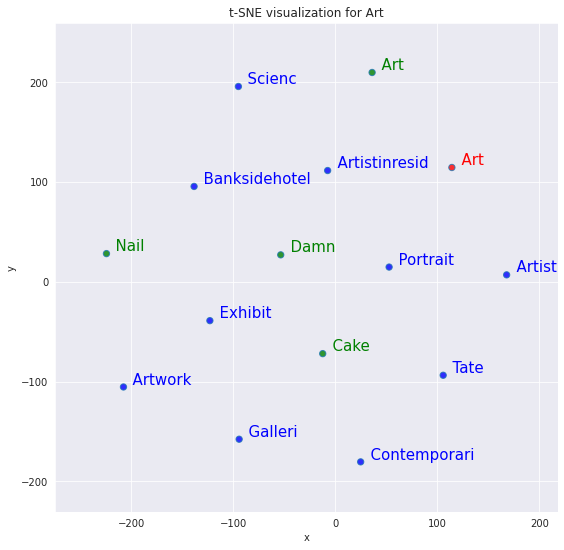

In [68]:
#10 most similar words vs 4 random words
tsnescatterplot(w2v_model_caption, 'art', ['damn', 'cake', 'nail', 'art'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


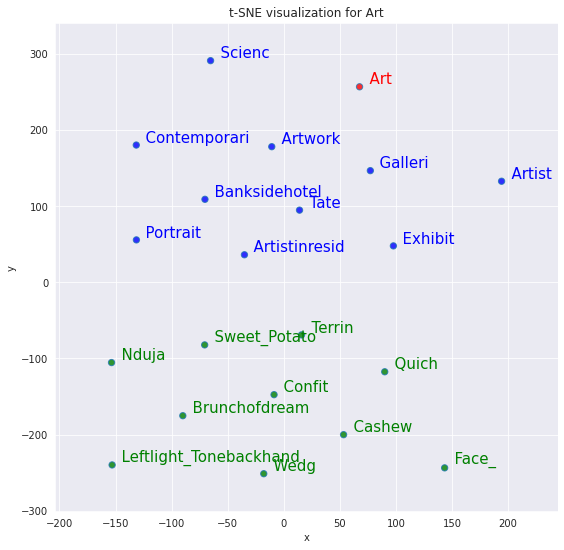

In [72]:
tsnescatterplot(w2v_model_caption, 'art', [i[0] for i in w2v_model_caption.wv.most_similar(negative=["art"])])

#Hashtags

In [229]:
new_data=data[data['hashtags']!='[]']
new_data=new_data.drop(['caption', 'biography'], axis=1)


<bound method NDFrame.head of                                                 hashtags
10     ['#chelseabridgeclinic', '#london', '#test', '...
11     ['#thankful', '#feedback', '#chlseabridgeclini...
12     ['#edinburghrestaurants', '#numberone', '#theb...
13     ['#michelinstar', '#michelinuk', '#edinburghfo...
14     ['#michelinstar', '#michelinuk', '#edinburghfo...
...                                                  ...
44151  ['#skincancerawareness', '#skincare', '#plasti...
44152  ['#diepflap', '#breastreconstruction', '#freep...
44153  ['#plasticsurgery', '#handsurgery', '#paediatr...
44157  ['#plasticsurgery', '#breastsurgery', '#breast...
44158  ['#wideawakehandsurgery', '#walant', '#flexort...

[26444 rows x 1 columns]>

In [259]:

new_data=new_data.apply(lambda x: x.astype(str).str.lstrip('['))
new_data=new_data.apply(lambda x: x.astype(str).str.replace("'",''))
new_data=new_data.apply(lambda x: x.astype(str).str.replace(",",''))
new_data=new_data.apply(lambda x: x.astype(str).str.replace("#",''))
new_data=new_data.apply(lambda x: x.astype(str).str.rstrip(']'))

In [260]:
new_data

,hashtags
10,hogmanay happynewyear 2022 michelin michelinst...
11,michelinstar michelinuk edinburghfoodies edinb...
12,michelinstar michelinuk edinburghfoodies edinb...
13,michelinstar michelinuk edinburghfoodies edinb...
14,michelinstar michelinuk edinburghfoodies edinb...
...,...
44151,skincancerawareness skincare plasticsurgery re...
44152,diepflap breastreconstruction freeplasticsurge...
44153,plasticsurgery handsurgery paediatricsurgery c...
44157,plasticsurgery breastsurgery breastreduction c...


In [281]:
sent_hash = [str(row).split() for row in new_data['hashtags']]

In [282]:
phrases = Phrases(sent_hash, min_count=30, progress_per=10000)

INFO - 13:30:05: collecting all words and their counts
INFO - 13:30:05: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:30:06: PROGRESS: at sentence #10000, processed 112462 words and 72252 word types
INFO - 13:30:06: PROGRESS: at sentence #20000, processed 226970 words and 91647 word types
INFO - 13:30:06: collected 103252 word types from a corpus of 302946 words (unigram + bigrams) and 26444 sentences
INFO - 13:30:06: using 103252 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [283]:
bigram_hash = Phraser(phrases)

INFO - 13:30:07: source_vocab length 103252
INFO - 13:30:08: Phraser built with 953 phrasegrams


In [284]:
sentences_hash = bigram_hash[sent_hash]

In [285]:
w2v_model_hash = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [286]:
t = time()

w2v_model_hash.build_vocab(sentences_hash, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:30:16: collecting all words and their counts
INFO - 13:30:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:30:17: PROGRESS: at sentence #10000, processed 99544 words, keeping 22635 word types
INFO - 13:30:17: PROGRESS: at sentence #20000, processed 197155 words, keeping 27501 word types
INFO - 13:30:17: collected 30320 word types from a corpus of 261151 raw words and 26444 sentences
INFO - 13:30:17: Loading a fresh vocabulary
INFO - 13:30:17: effective_min_count=20 retains 2771 unique words (9% of original 30320, drops 27549)
INFO - 13:30:17: effective_min_count=20 leaves 168217 word corpus (64% of original 261151, drops 92934)
INFO - 13:30:17: deleting the raw counts dictionary of 30320 items
INFO - 13:30:17: sample=6e-05 downsamples 2072 most-common words
INFO - 13:30:17: downsampling leaves estimated 88644 word corpus (52.7% of prior 168217)
INFO - 13:30:17: estimated required memory for 2771 words and 300 dimensions: 8035900 bytes
INFO - 13:

Time to build vocab: 0.03 mins


In [287]:
t = time()

w2v_model_hash.train(sentences_hash, total_examples=w2v_model_hash.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:30:21: training model with 1 workers on 2771 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:30:22: EPOCH 1 - PROGRESS: at 72.47% examples, 63299 words/s, in_qsize 1, out_qsize 0
INFO - 13:30:23: worker thread finished; awaiting finish of 0 more threads
INFO - 13:30:23: EPOCH - 1 : training on 261151 raw words (88881 effective words) took 1.4s, 65111 effective words/s
INFO - 13:30:24: EPOCH 2 - PROGRESS: at 76.39% examples, 65000 words/s, in_qsize 0, out_qsize 0
INFO - 13:30:24: worker thread finished; awaiting finish of 0 more threads
INFO - 13:30:24: EPOCH - 2 : training on 261151 raw words (88903 effective words) took 1.3s, 66603 effective words/s
INFO - 13:30:25: EPOCH 3 - PROGRESS: at 72.47% examples, 63600 words/s, in_qsize 0, out_qsize 0
INFO - 13:30:25: worker thread finished; awaiting finish of 0 more threads
INFO - 13:30:25: EPOCH - 3 : training on 261151 raw words (88476 effective words) took 1.3s, 66153 effective words/s
IN

Time to train the model: 0.65 mins


In [288]:
w2v_model_hash.wv.vocab

{'happynewyear': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91390>,
 '2022': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91fd0>,
 'michelin': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91850>,
 'michelinstar': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91110>,
 'edinburghfoodies': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc911d0>,
 'edinburghrestaurants': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91b50>,
 'numberone': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91450>,
 'thebalmoral_roccofortehotels': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91790>,
 'roccofortefriends_edinburgh': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc912d0>,
 'igersedinburgh_scotland': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91990>,
 'visitedinburgh_foreveredinburgh': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91950>,
 'visitscotland_scotlandisnow': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc91190>,
 'travel': <gensim.models.keyedvectors.Vocab at 0x7f2b3dc917d0>,
 'travelle

In [290]:
w2v_model_hash.wv.most_similar(positive=["happynewyear"])

[('2022', 0.827511191368103),
 ('newyear', 0.7736381888389587),
 ('fiveguysburgersandfries_5guys', 0.7362861633300781),
 ('londonedition', 0.7118107080459595),
 ('westburydublin', 0.6815880537033081),
 ('christmas2021', 0.6576865911483765),
 ('merrychristmas', 0.6500827074050903),
 ('christmasdecor', 0.6451953649520874),
 ('christmastree', 0.6424316167831421),
 ('chickentenders_crispychicken', 0.6323336362838745)]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


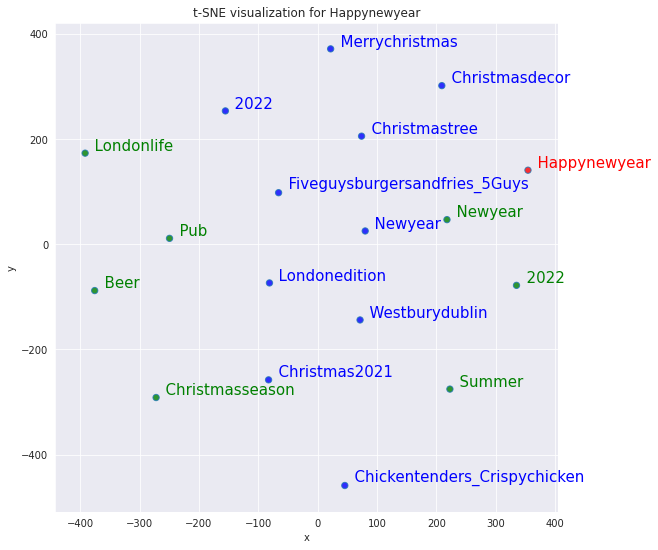

In [295]:
tsnescatterplot(w2v_model_hash, 'happynewyear', ['2022','newyear','summer', 'beer', 'christmasseason', 'londonlife', 'pub'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


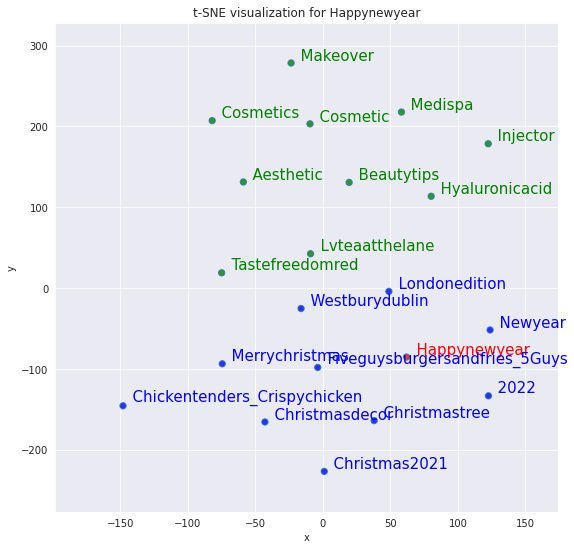

In [296]:
tsnescatterplot(w2v_model_hash, 'happynewyear', [i[0] for i in w2v_model_hash.wv.most_similar(negative=["happynewyear"])])

#Biography

In [297]:
sent_bio = [str(row).split() for row in data['biography']]


In [298]:
phrases = Phrases(sent_bio, min_count=30, progress_per=10000)

INFO - 13:46:06: collecting all words and their counts
INFO - 13:46:06: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:46:06: PROGRESS: at sentence #10000, processed 144530 words and 4546 word types
INFO - 13:46:07: PROGRESS: at sentence #20000, processed 282657 words and 7276 word types
INFO - 13:46:07: PROGRESS: at sentence #30000, processed 420143 words and 9023 word types
INFO - 13:46:07: PROGRESS: at sentence #40000, processed 560109 words and 9895 word types
INFO - 13:46:07: collected 10263 word types from a corpus of 617565 words (unigram + bigrams) and 44159 sentences
INFO - 13:46:07: using 10263 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [299]:
bigram_bio = Phraser(phrases)

INFO - 13:46:07: source_vocab length 10263
INFO - 13:46:07: Phraser built with 1829 phrasegrams


In [305]:
sentences_bio = bigram_bio[sent_bio]

In [306]:
w2v_model_bio = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [307]:
t = time()

w2v_model_bio.build_vocab(sentences_bio, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:47:21: collecting all words and their counts
INFO - 13:47:21: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:47:21: PROGRESS: at sentence #10000, processed 118994 words, keeping 1506 word types
INFO - 13:47:22: PROGRESS: at sentence #20000, processed 231182 words, keeping 2307 word types
INFO - 13:47:22: PROGRESS: at sentence #30000, processed 342765 words, keeping 2775 word types
INFO - 13:47:23: PROGRESS: at sentence #40000, processed 454786 words, keeping 3012 word types
INFO - 13:47:23: collected 3107 word types from a corpus of 500683 raw words and 44159 sentences
INFO - 13:47:23: Loading a fresh vocabulary
INFO - 13:47:23: effective_min_count=20 retains 2612 unique words (84% of original 3107, drops 495)
INFO - 13:47:23: effective_min_count=20 leaves 497242 word corpus (99% of original 500683, drops 3441)
INFO - 13:47:23: deleting the raw counts dictionary of 3107 items
INFO - 13:47:23: sample=6e-05 downsamples 1487 most-common words
INFO - 

Time to build vocab: 0.04 mins


In [308]:
t = time()

w2v_model_bio.train(sentences_bio, total_examples=w2v_model_bio.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:47:23: training model with 1 workers on 2612 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:47:24: EPOCH 1 - PROGRESS: at 34.88% examples, 77226 words/s, in_qsize 0, out_qsize 0
INFO - 13:47:25: EPOCH 1 - PROGRESS: at 73.39% examples, 78364 words/s, in_qsize 0, out_qsize 0
INFO - 13:47:26: worker thread finished; awaiting finish of 0 more threads
INFO - 13:47:26: EPOCH - 1 : training on 500683 raw words (216915 effective words) took 2.7s, 80190 effective words/s
INFO - 13:47:27: EPOCH 2 - PROGRESS: at 36.99% examples, 78701 words/s, in_qsize 0, out_qsize 0
INFO - 13:47:28: EPOCH 2 - PROGRESS: at 75.25% examples, 79333 words/s, in_qsize 0, out_qsize 0
INFO - 13:47:29: worker thread finished; awaiting finish of 0 more threads
INFO - 13:47:29: EPOCH - 2 : training on 500683 raw words (216999 effective words) took 2.7s, 81081 effective words/s
INFO - 13:47:30: EPOCH 3 - PROGRESS: at 36.99% examples, 80764 words/s, in_qsize 0, out_qsize 0


Time to train the model: 1.34 mins


In [309]:
w2v_model_bio.wv.vocab

{'nan': <gensim.models.keyedvectors.Vocab at 0x7f2b4196e1d0>,
 'globe': <gensim.models.keyedvectors.Vocab at 0x7f2b41965450>,
 'show': <gensim.models.keyedvectors.Vocab at 0x7f2b41965550>,
 'america': <gensim.models.keyedvectors.Vocab at 0x7f2b41965d90>,
 'place': <gensim.models.keyedvectors.Vocab at 0x7f2b41965090>,
 'beverag': <gensim.models.keyedvectors.Vocab at 0x7f2b41968890>,
 'consult': <gensim.models.keyedvectors.Vocab at 0x7f2b419684d0>,
 'reconstruct': <gensim.models.keyedvectors.Vocab at 0x7f2b41968a90>,
 'coach': <gensim.models.keyedvectors.Vocab at 0x7f2b41965ed0>,
 'doctor': <gensim.models.keyedvectors.Vocab at 0x7f2b419652d0>,
 'husband': <gensim.models.keyedvectors.Vocab at 0x7f2b41968790>,
 'black': <gensim.models.keyedvectors.Vocab at 0x7f2b41968750>,
 'small': <gensim.models.keyedvectors.Vocab at 0x7f2b41968dd0>,
 'squar': <gensim.models.keyedvectors.Vocab at 0x7f2b41968950>,
 'gener': <gensim.models.keyedvectors.Vocab at 0x7f2b41968e90>,
 'health': <gensim.models.ke

INFO - 13:50:54: precomputing L2-norms of word weight vectors
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


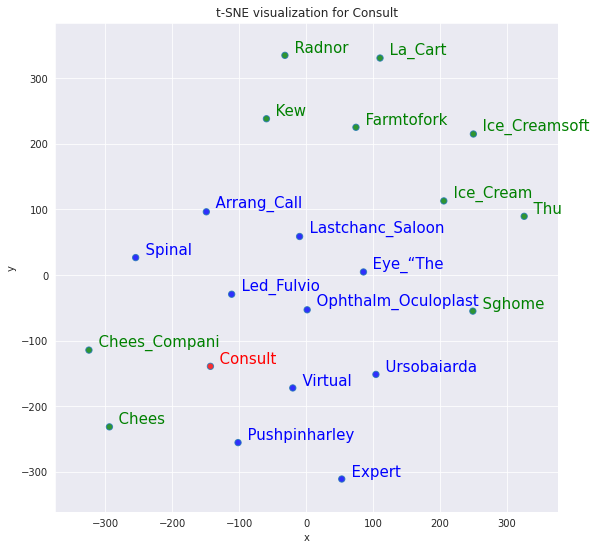

In [311]:
tsnescatterplot(w2v_model_bio, 'consult', [i[0] for i in w2v_model_bio.wv.most_similar(negative=["consult"])])